In [17]:
import pyro
import torch
pyro.set_rng_seed(101)

import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt

import numpy as np
from collections import Counter
from googlesearch import search

In [2]:
alias = {'entity1':['person','animal'],
         'entity2':['person','animal'],
         'position1':['left','right'], 
         'position2':['left','right'], 
         'haircolor':['black', 'brown','red','golden'],
         'hairlength':['short','long'],
         'gender':['male','female'],
         'age':['young','old'],
         'color':['black', 'white', 'brown'],
         'size':['little','large'],
         'type':['cat','dog'],
         'background':['park','home'],
         'interaction':['fight','chase','call','hold']
        }

prob = {'entity1':torch.tensor([0.5,0.5]), 
        'entity2':torch.tensor([0.5,0.5]), 
        'position1':torch.tensor([0.5,0.5]), 
        'position2':torch.tensor([0.5,0.5]), 
        'haircolor':torch.tensor([0.25, 0.25,0.25,0.25]),
        'hairlength':torch.tensor([0.5,0.5]),
        'gender':torch.tensor([0.5,0.5]),
        'age':torch.tensor([0.5,0.5]),
        'color':torch.tensor([1/3,1/3,1/3]),
        'size':torch.tensor([0.5,0.5]),
        'type':torch.tensor([0.5,0.5]),
        'background':torch.tensor([0.5,0.5]),
        'interaction':torch.tensor([[[1/2,0,0,1/2],[0,1/2,1/2,0]], # e1=left, [e2=left. e2=right]
                                     [[0,1/2,1/2,0],[1/2,0,0,1/2]]]) # e1=right, [e2=left. e2=right]
       }

In [3]:
class Person(object):
    def __init__(self):
        self.position1 = pyro.sample("position1", dist.Categorical(probs=prob['position1'])) 
        self.haircolor = pyro.sample("haircolor", dist.Categorical(probs=prob['haircolor']))
        self.hairlength = pyro.sample("hairlength", dist.Categorical(probs=prob['hairlength']))
        self.gender = pyro.sample("gender", dist.Categorical(probs=prob['gender']))
        self.age = pyro.sample("age", dist.Categorical(probs=prob['age']))

In [4]:
class Animal(object):
    def __init__(self):
        self.position2 = pyro.sample('position2', dist.Categorical(prob['position2']))
        self.color = pyro.sample('color', dist.Categorical(prob['color']))
        self.size = pyro.sample('size', dist.Categorical(prob['size']))
        self.type = pyro.sample('type', dist.Categorical(prob['type']))

In [5]:
def generateEntity():
    entity = pyro.sample("entity", dist.Categorical(probs=prob['entity']))
    if entity == 0:
        return Person()
    else:
        return Animal()

In [6]:
class Background(object):
    def __init__(self):
        self.background = pyro.sample('background', dist.Categorical(prob['background']))

In [7]:
class Interaction(object):
    def __init__(self, entity1, entity2):
        self.interaction = pyro.sample('interaction', dist.Categorical(prob['interaction'][entity1.position1][entity2.position2]))

In [8]:
def model():
    person = Person()
    animal = Animal()
    background = Background()
    interaction = Interaction(person, animal)

In [9]:
def condition(model, evidence, num_samples = 1000):
    condition_model = pyro.condition(model, data=evidence)
    posterior = pyro.infer.Importance(condition_model, num_samples=num_samples).run()
    return posterior

In [10]:
def intervention(model, evidence, num_samples = 1000):
    do_model = pyro.do(model, data=evidence)
    posterior = pyro.infer.Importance(do_model, num_samples=num_samples).run()
    return posterior

In [11]:
def pltDistribution(posterior, infer, num_samples = 1000):
    for i in range(len(infer)):
        marginal = EmpiricalMarginal(posterior, infer[i])
        samples = [marginal().item() for _ in range(num_samples)]
        unique, counts = np.unique(samples, return_counts=True)
        plt.figure(i)
        plt.bar(unique, counts / num_samples, align='center')
        plt.xticks(unique, alias[infer[i]])
        plt.ylabel('prob')
        plt.xlabel(infer[i])

In [12]:
def mostOccurance(posterior, infer, num_samples = 1000):
    sample = []
    for i in range(num_samples): 
        trace = posterior()
        value = []
        for i in range(len(infer)):
            value.append(trace.nodes[infer[i]]['value'])
        sample.append(tuple(value))

    most_common, num_most_common = Counter(sample).most_common(1)[0]
    
    infer_dict = {}
    for i in range(len(infer)):
        infer_dict[infer[i]] = alias[infer[i]][most_common[i]]
    return infer_dict

In [13]:
def getEntity(input_dic):
    dic = {}
    person = Person()
    animal = Animal()
    background = Background()
    interaction = Interaction(person,animal)
    entity_list = [person,animal,background,interaction]
    for k in entity_list:
        entity_dic = k.__dict__
        dic.update(entity_dic)
        
    for k in dic:
        dic[k] = alias[k][dic[k]]
    dic.update(input_dic)
    return dic

In [14]:
def getScene(input_dict):
    scene = str("A %s %s with %s %s hair %s a %s %s %s %s." % 
                (input_dict['age'],input_dict['gender'],input_dict['haircolor'],input_dict['hairlength'],
                 input_dict['interaction'],input_dict['size'],input_dict['color'],input_dict['type'],
                 input_dict['background']))
    print(scene)
    return scene

In [15]:
def getPic(input_str,num_s=3):
    for j in search(input_str, tld="com", num = num_s, start = 0, stop=5, pause=2): 
        print(j) 

A old male with red short hair call a large white dog park.
https://animalfriendsofthevalleys.com/lost-found-reports-2/
http://z1077fm.com/z-nation/cruisin-critter-report/
https://arfok.org/pages/lost-found-archives
https://www.purina.com/dogs/dog-breeds/collections/short-haired-dog-breeds
https://www.animalallies.net/lost-and-found-pets


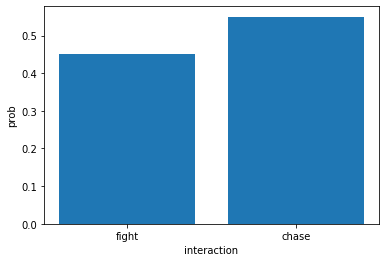

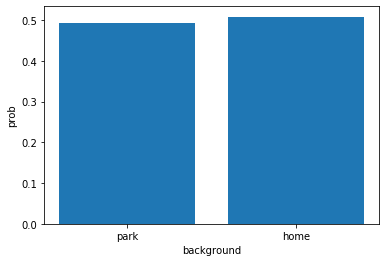

In [18]:
evidence = {'position1':torch.tensor(1),'position2':torch.tensor(0)}
infer = ['interaction', 'background']
infer_model = condition(model, evidence)
pltDistribution(infer_model, infer)
infer_res = mostOccurance(infer_model, infer)
getPic(getScene(getEntity(infer_res)))